_Lambda School Data Science — Tree Ensembles_ 

# Gradient Boosting

### Pre-reads
- [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
- [A Kaggle Master Explains Gradient Boosting](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/) — _Don’t worry about formulas/equations, but do see the good examples and explanations_
- [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf) Chapter 8.2.3, Boosting:

>Recall that bagging involves creating multiple copies of the original training data set using the bootstrap, fitting a separate decision tree to each copy, and then combining all of the trees in order to create a single predictive model.

>**Boosting works in a similar way, except that the trees are grown _sequentially_: each tree is grown using information from previously grown trees.**

>Unlike fitting a single large decision tree to the data, which amounts to _fitting the data hard_ and potentially overfitting, the boosting approach instead _learns slowly._ Given the current model, we fit a decision tree to the residuals from the model.

>We then add this new decision tree into the fitted function in order to update the residuals. Each of these trees can be rather small, with just a few terminal nodes. **By fitting small trees to the residuals, we slowly improve fˆ in areas where it does not perform well.**

>Note that in boosting, unlike in bagging, the construction of each tree depends strongly on the trees that have already been grown.

If you want to go deeper, Terence Parr & Jeremy Howard have a [4 part series and recommended links](https://explained.ai/gradient-boosting/index.html).

### Python libraries with Gradient Boosting implementations
- [scikit-learn — Gradient Tree Boosting](https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting)
- [xgboost](https://xgboost.readthedocs.io/en/latest/)
  - Anaconda: `conda install -c conda-forge xgboost`
  - Google Colab: already installed
- [LightGBM](https://lightgbm.readthedocs.io/en/latest/)
  - Anaconda: `conda install -c conda-forge lightgbm`
  - Google Colab: already installed

### XGBoost strengths
- **Accuracy** _(versus other algorithms, for many tabular datasets — but be aware of "No Free Lunch" theorem)_
- **Speed** _(versus scikit-learn's Gradient Boosting implementation)_
- Can accept **missing values**
- Can enforce **monotonic constraints**

### Monotonic constraints

_From [**Ideas on interpreting machine learning**](https://www.oreilly.com/ideas/ideas-on-interpreting-machine-learning) by Patrick Hall, Wen Phan, and SriSatish Ambati_

![](https://d3ansictanv2wj.cloudfront.net/figure_13-5c27095f0fc9ea57132fa54fd88f0fee.jpg)

> **Monotonicity is often expected by regulators:** no matter what a training data sample says, regulators may still want to see monotonic behavior. Consider savings account balances in credit scoring. A high savings account balance should be an indication of creditworthiness, whereas a low savings account balance should be an indicator of potential default risk. If a certain batch of training data contains many examples of individuals with high savings account balances defaulting on loans or individuals with low savings account balances paying off loans, of course a machine-learned response function trained on this data would be non-monotonic with respect to savings account balance. This type of predictive function could be unsatisfactory to regulators because it defies decades of accumulated domain expertise and thus decreases trust in the model or sample data.


> **Monotonicity enables consistent reason code generation:** consistent reason code generation is generally considered a gold standard of model interpretability. If monotonicity is guaranteed by a credit scoring model, reasoning about credit applications is straightforward and automatic. If someone's savings account balance is low, their credit worthiness is also low. Once monotonicity is assured, reasons for credit decisions can then be reliably ranked...

### More about monotonic constraints and interpretability
- [XGBoost Tutorials — Monotonic Constraints](https://xgboost.readthedocs.io/en/latest/tutorials/monotonic.html)
- [A Tutorial of Model Monotonicity Constraint Using Xgboost](https://xiaoxiaowang87.github.io/monotonicity_constraint/)
- [A curated list of awesome machine learning interpretability resources](https://github.com/jphall663/awesome-machine-learning-interpretability)

# XGBoost examples

## 1. Scikit-Learn API, Missing Values
- [XGBoost FAQ: How to deal with missing values](https://xgboost.readthedocs.io/en/latest/faq.html?highlight=missing#how-to-deal-with-missing-value)
- [XGBoost Python API Reference: Scikit-Learn API](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn) (`XGBRegressor` and `XGBClassifier`)

In this example, we load Titanic data and encode categoricals as ordinals, but do _not_ impute missing values:

In [1]:
import category_encoders as ce
import pandas as pd
import seaborn as sns

titanic = sns.load_dataset('titanic')
X = titanic[['age', 'class', 'deck', 'embarked', 'fare', 'sex']]
y = titanic['survived']

encoder = ce.OrdinalEncoder(handle_unknown='ignore', cols=['class', 'deck', 'embarked', 'sex'])
X_transformed = encoder.fit_transform(X)
X_transformed.head(10)

,age,class,deck,embarked,fare,sex
0,22.0,1,-9223372036854775808,1,7.2500,1
1,38.0,2,2,2,71.2833,2
2,26.0,1,-9223372036854775808,1,7.9250,2
3,35.0,2,2,1,53.1000,2
4,35.0,1,-9223372036854775808,1,8.0500,1
5,NaN,1,-9223372036854775808,3,8.4583,1
6,54.0,2,3,1,51.8625,1
7,2.0,1,-9223372036854775808,1,21.0750,1
8,27.0,1,-9223372036854775808,1,11.1333,2
9,14.0,3,-9223372036854775808,2,30.0708,2


In [2]:
X_transformed.isnull().sum()

age         177
class         0
deck          0
embarked      0
fare          0
sex           0
dtype: int64

`XGBClassifier` can be used like a scikit-learn estimator, but it works with missing values!

In [3]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

model = XGBClassifier()
cross_val_score(model, X_transformed, y, scoring='accuracy', cv=5, n_jobs=-1)

array([0.79329609, 0.82122905, 0.85393258, 0.79213483, 0.84180791])

## 2. Learning API, early stopping, monotonic constraints

***This example is adapted from [A Tutorial of Model Monotonicity Constraint Using Xgboost](https://xiaoxiaowang87.github.io/monotonicity_constraint/)***

>  For a tree-based model, if for each split of a particular variable we require the right daughter node’s average value to be higher than the left daughter node (otherwise the split will not be made), then approximately this predictor’s relationship with the dependent variable is monotonically increasing; and vise versa.

> I’m going to use the California Housing dataset for this tutorial. This dataset consists of 20,460 observations. Each observation represents a neighborhood in California. The response variable is the median house value of a neighborhood. Predictors include median income, average house occupancy, and location etc. of that neighborhood.

In [6]:
from sklearn.datasets.california_housing import fetch_california_housing
from sklearn.model_selection import train_test_split

california_housing = fetch_california_housing()
columns = ['Median Income', 'House Age', 'Average Rooms', 
           'Average Bedrooms', 'Population', 'Average Occupancy', 
           'Latitude', 'Longitude']

X = pd.DataFrame(california_housing.data, columns=columns)
X['Median Income'] = X['Median Income'] * 10000
y = pd.Series(california_housing.target * 100000, name='Median House Value')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=123)

print(california_housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

> To start, we use a single feature “the median income” to predict the house value.  We first split the data into training and testing datasets. Then We use a 5-fold cross-validation and early-stopping on the training dataset to determine the best number of trees. Last, we use the entire training set to train my model and evaluate its performance on the testset.

> Notice the model parameter `'monotone_constraints'`. This is where the monotonicity constraints are set in Xgboost. For now I set `'monotone_constraints': (0)`, which means a single feature without constraint.

[XGBoost Data Interface](https://xgboost.readthedocs.io/en/latest/python/python_intro.html#data-interface)

In [7]:
import xgboost as xgb

features = ['Median Income']
dtrain = xgb.DMatrix(X_train[features], label=y_train)
dtest = xgb.DMatrix(X_test[features], label=y_test)

- [Enforcing Monotonic Constraints in XGBoost](https://xgboost.readthedocs.io/en/latest/tutorials/monotonic.html#enforcing-monotonic-constraints-in-xgboost)
- [XGBoost Tutorials: Notes on Parameter Tuning](https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html)
- [XGBoost Python API Reference: Learning API](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.training)
- [xgboost.cv](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.cv) parameters
  - params (dict) – Booster params.
  - dtrain (DMatrix) – Data to be trained.
  - num_boost_round (int) – Number of boosting iterations.
  - nfold (int) – Number of folds in CV.
  - early_stopping_rounds (int) – Activates early stopping. CV error needs to decrease at least every <early_stopping_rounds> round(s) to continue. Last entry in evaluation history is the one from best iteration.
  - as_pandas (bool, default True) – Return pd.DataFrame when pandas is installed. If False or pandas is not installed, return np.ndarray

In [11]:
import matplotlib.pyplot as plt 
plt.style.use('dark_background')


params = {'monotone_constraints': '(0)', # no constraint
          'max_depth': 2,
          'eta': 0.1,
          'silent': 1, 
          'n_jobs': -1,
          'seed': 0,
          'eval_metric': 'rmse'}

# Without early stopping
bst_cv = xgb.cv(params, dtrain, num_boost_round=1000, nfold=5, early_stopping_rounds=None, as_pandas=True)

In [12]:
bst_cv.tail()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
995,77085.585937,402.500326,83257.420312,1451.553891
996,77082.285938,401.628753,83258.685938,1452.294357
997,77080.209375,401.352555,83259.354687,1452.372700
998,77077.253125,400.829001,83258.831250,1452.822201
999,77073.826563,400.299076,83260.523437,1450.587516


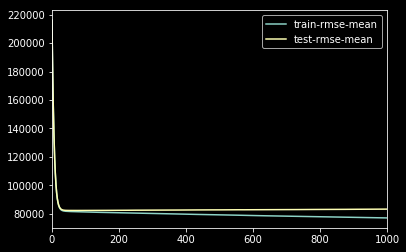

In [13]:
bst_cv[['train-rmse-mean', 'test-rmse-mean']].plot();

In [14]:
# With early stopping. Use CV to find the best number of trees
bst_cv = xgb.cv(params, dtrain, num_boost_round=1000, nfold=5, early_stopping_rounds=10, as_pandas=True)

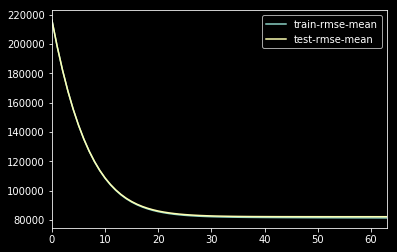

In [15]:
bst_cv[['train-rmse-mean', 'test-rmse-mean']].plot();

In [16]:
bst = xgb.train(params, dtrain, num_boost_round=60)
print(bst.eval(dtest))

[0]	eval-rmse:82873.148438


> We can also check the relationship between the feature (median income) and the dependent variable (median house value)

**Bad News:** [PDPbox](https://github.com/SauceCat/PDPbox) works with scikit-learn, but not xgboost :-(

**Good News:** [The tutorial](https://xiaoxiaowang87.github.io/monotonicity_constraint/) has a custom partial dependency function. We can adapt it and get a better understanding [how partial dependence plots work](https://twitter.com/ChristophMolnar/status/1066398522608635904)!

> Here I wrote a helper function partial_dependency to calculate the variable dependency or partial dependency for an arbitrary model. The partial dependency describes that when other variables fixed, how the average response depends on a predictor.

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import numpy as np

def partial_dependency(bst, X, y, feature):
    """
    Calculate the dependency (or partial dependency) of a response variable on a predictor (or multiple predictors)
    1. Sample a grid of values of a predictor.
    2. For each value, replace every row of that predictor with this value, calculate the average prediction.
    """

    X_temp = X.copy()
    
    grid = np.linspace(start=np.percentile(X_temp[feature], 0.1),
                       stop=np.percentile(X_temp[feature], 99.5),
                       num=50)
    
    y_pred = np.zeros(len(grid))

    for i, value in enumerate(grid):
        X_temp[feature] = value
        data = xgb.DMatrix(X_temp)
        y_pred[i] = np.average(bst.predict(data, ntree_limit=bst.best_ntree_limit))

    plt.plot(grid, y_pred, '-', color='red', linewidth=2.5)
    plt.plot(X, y, 'o', color='grey', alpha=0.01)
    plt.xlim(min(grid), max(grid))
    plt.xlabel(feature)
    plt.ylabel(y.name)
    plt.show()


> Without any monotonicity constraint, the relationship between the median income and median house value looks like this:

(0)


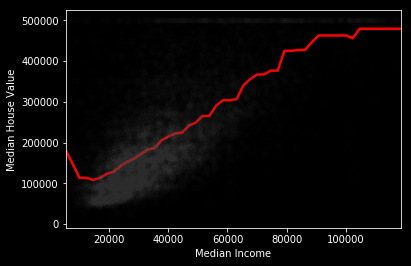

In [19]:
print(params['monotone_constraints'])

partial_dependency(bst, X_train[features], y_train, feature='Median Income')

> One can see that at very low income and income around 10 (times its unit), the relationship between median income and median house value is not strictly monotonic.

> You may be able to find some explanations for this non-monotonic behavior (e.g. feature interactions). In some cases, it may even be a real effect which still holds true after more features are fitted. If you are very convinced about that, I suggest you not enforce any monotonic constraint on the variable, otherwise important relationships may be ignored. But when the non-monotonic behavior is purely because of noise, setting monotonic constraints can reduce overfitting.

> For this example, it is hard to justify that neighborhoods with a low median income have a high median house value. Therefore we will try enforcing the monotonicity on the median income:

In [20]:
params['monotone_constraints'] = '(1)'

> We then ... refit the model and evaluate it on the testset. Below is the result:

In [21]:
bst = xgb.train(params, dtrain, num_boost_round=60)
print(bst.eval(dtest))

[0]	eval-rmse:82792.945312


> We may have reduced overfitting and improved our performance on the testset. However, given that statistical uncertainties on these numbers are probably just as big as the differences, it is just a hypothesis. For this example, the bottom line is that adding monotonicity constraint does not significantly hurt the performance.

> Now we can check the variable dependency again:

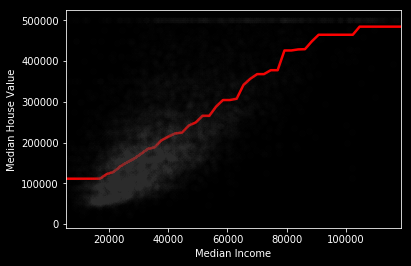

In [22]:
partial_dependency(bst, X_train[features], y_train, feature='Median Income')

> Great! Now the response is monotonically increasing with the predictor. This model has also become a bit easier to explain.

> We can also enforce monotonicity constraints while fitting multiple features. For example:

[0]	eval-rmse:70115.710938


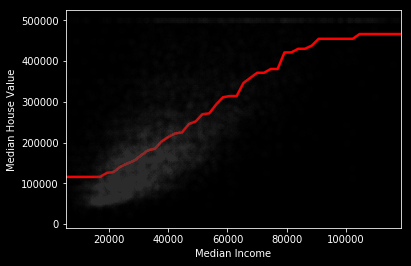

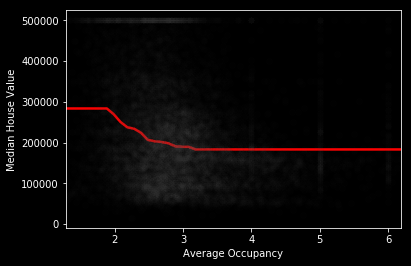

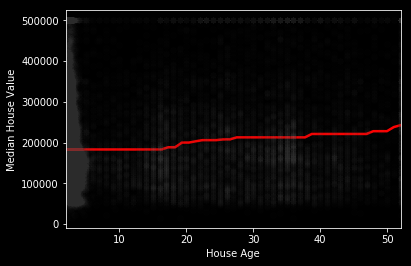

In [23]:
features = ['Median Income', 'Average Occupancy', 'House Age']
params['monotone_constraints'] = '(1, -1, 1)'

dtrain = xgb.DMatrix(X_train[features], label=y_train)
dtest = xgb.DMatrix(X_test[features], label=y_test)

bst = xgb.train(params, dtrain, num_boost_round=60)
print(bst.eval(dtest))

for feature in features:
    partial_dependency(bst, X_train[features], y_train, feature=feature)

> We assume that median house value is positively correlated with median income and house age, but negatively correlated with average house occupancy.

> Is it a good idea to enforce monotonicity constraints on features? It depends. For the example here, I didn’t see a significant performance decrease, and I think the directions of these variables make intuitive sense. For other cases, especially when the number of variables is large, it may be difficult and even dangerous to do so. It certainly relies on a lot of domain expertise and exploratory analysis to fit a model that is “as simple as possible, but no simpler”.